In [1]:
import json
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from pathlib import Path
import torch as th

%load_ext autoreload
%autoreload 3
sys.path.append("..")
sys.path.append("../generalization")
from time import time
from coolname import generate_slug, get_combinations_count

In [2]:
from display_utils import plot_ci


def preprocess_dict(json_dic, do_relabel=True, merge_lang=[]):
    if isinstance(merge_lang, str):
        merge_lang = [merge_lang]

    if do_relabel:
        json_dic = relabel(json_dic)
    for lang in merge_lang:
        probs = []
        keys = []
        for key, prob in json_dic.items():
            if lang in key:
                probs.append(prob)
                keys.append(key)
        for key in keys:
            del json_dic[key]
        if keys:
            json_dic[f"src + tgt {lang}"] = np.mean(probs, axis=0).tolist()
        else:
            print(f"No entry found for {lang}")
    for k, v in json_dic.items():
        print(f"{k}: {len(v)}")
    return json_dic


def plot_dict(
    json_dic,
    title="",
    skip=[],
    colors=None,
    ax=None,
    do_y_label=True,
    processing=True,
    do_probs_hor=True,
    baseline_colors=None,
    legend=True,
    save_png=False,
    **proc_kwargs,
):
    if processing:
        json_dic = preprocess_dict(json_dic, **proc_kwargs)

    fig = None
    if ax is None:
        fig, ax = plt.subplots(figsize=(6, 5))

    if colors is None:
        colors = sns.color_palette("tab10", len(json_dic) + 1)
    colors_it = iter(colors)
    if baseline_colors is None:
        baseline_colors = [colors[0], colors[3] if len(colors) > 3 else colors[1]]
    first = True
    for latent_lang in json_dic.keys():
        if "baseline" in latent_lang or latent_lang in skip:
            continue
        if "probs" in latent_lang:
            if do_probs_hor:
                is_source = "src" in latent_lang or "source" in latent_lang
                color = baseline_colors[0] if is_source else baseline_colors[1]
                ax.axhline(
                    np.mean(json_dic[latent_lang]),
                    # label=latent_lang,
                    color=color,
                    linestyle="--" if is_source else "-.",
                    alpha=0.6,
                )
            continue
        probs = th.tensor(json_dic[latent_lang])
        num_layers = probs.shape[1]
        plot_ci(
            ax,
            probs,
            label=latent_lang,
            color=next(colors_it),
            init=first,
            tik_step=5,
        )
        first = False
    if legend:
        ax.legend()
    ax.set_title(title)
    print(num_layers)
    ax.tick_params(labelsize=15)
    ax.set_xlabel("layer", fontsize=16)
    if do_y_label:
        ax.set_ylabel("concept probability", fontsize=16)
    ax.set_xlim(0, num_layers - 1)
    ax.set_ylim(0, 1)
    if fig is not None:
        fig.tight_layout()
    # Save the plot
    id = str(int(time())) + generate_slug(2)
    if save_png:
        path = Path(f"plots/{id}.png")
        path.parent.mkdir(parents=True, exist_ok=True)
        plt.savefig(path, dpi=300, bbox_inches="tight")
    path = Path(f"plots/{id}.pdf")
    path.parent.mkdir(parents=True, exist_ok=True)
    plt.savefig(path, dpi=300, bbox_inches="tight")
    print(f"Saved plot to {path}")
    plt.show()


def load_dict(file):
    with open(file, "r") as f:
        json_dic = json.load(f)
    return json_dic


def relabel(dic):
    dic2 = {}
    for key in dic.keys():
        val = dic[key]
        if "lang" in key:
            continue
        elif "source_" in key:
            dic2[key.replace("source_", "src ")] = val
        elif "src" in key or "tgt" in key:
            dic2[key] = val
        elif "probs" in key:
            dic2[key] = val
        else:
            dic2["tgt " + key] = val
    return dic2


def plot_file(file, title="", skip=[], **kwargs):
    json_dic = load_dict(file)
    plot_dict(json_dic, title, skip, **kwargs)

In [3]:
def rearange(dic, merge_lang=[]):
    dic2 = {}
    idx = [2, 3, 1, 0]
    idx2 = [1, 3, 2, 0]
    colors = sns.color_palette("tab10", len(dic) + 1)
    colors = [colors[i] for i in idx2] + colors[4:]
    keys = [k for k in dic.keys() if "probs" not in k] + [k for k in dic.keys() if "probs" in k]
    keys3 = [keys[i] for i in idx] + keys[4:]
    for key in keys3:
        dic2[key] = dic[key]
    return dic2, colors

def rearange_and_plot(file, **kwargs):
    dic = load_dict(file)
    dic2 = relabel(dic)
    dic3, colors = rearange(dic2)
    plot_dict(dic3, colors=colors, **kwargs)

def rearange_and_plot2(file, merge_lang="en"):
    dic = load_dict(file)
    dic = preprocess_dict(dic, merge_lang="en")
    dic, colors = rearange(dic)
    plot_dict(dic, do_y_label=False, processing=False, colors=colors)

def exp2(file, **kwargs):
    dic = load_dict(file)
    # dic["source_zh"] = dic["source_zh"]
    # dic["zh"] = dic["zh"]
    # dic["src + tgt en"] = dic["src + tgt en"]
    dic2 = {
        "source_zh": dic["source_zh"],
        "zh": dic["zh"],
        "src + tgt en": dic["src + tgt en"],
        "source prompt probs": dic["source prompt probs"],
        "target prompt probs": dic["target prompt probs"],
    }
    plot_dict(dic2, baseline_colors=["tab:orange", "tab:blue"], colors=["tab:orange", "tab:blue", "tab:purple"], **kwargs)

tgt zh: 200
source prompt probs: 200
target prompt probs: 200
tgt it: 200
src it: 200
src zh: 200
src + tgt en: 200
32
Saved plot to plots/1722294368icy-crow.pdf


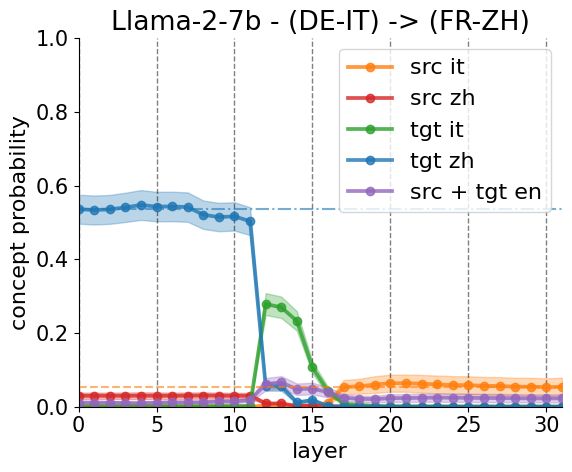

In [4]:
name = "1722292925_crimson-kingfisher"
dic = load_dict(f"/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/shifted_cross_translation/de_it-fr_zh-/{name}.json")
dic = preprocess_dict(dic, merge_lang="en")
dic, colors = rearange(dic)
plot_dict(dic, do_y_label=True, processing=False, colors=colors, title="Llama-2-7b - (DE-IT) -> (FR-ZH)", save_png=True) 

## Tweet

tgt zh: 200
source prompt probs: 200
target prompt probs: 200
tgt it: 200
src it: 200
src zh: 200
src + tgt en: 200
32
Saved plot to plots/1721043748sepia-grouse.pdf


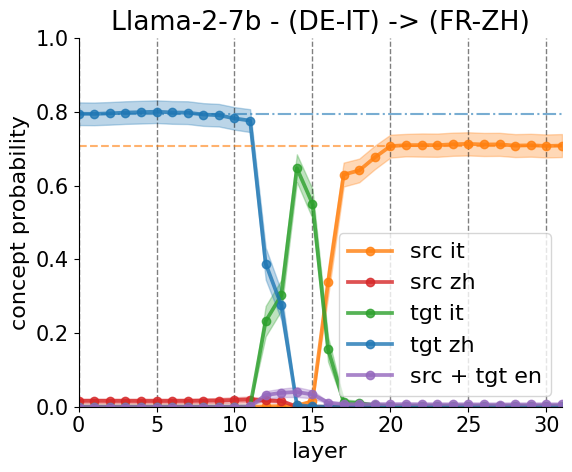

In [4]:
dic = load_dict("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/shifted_cross_translation/de_it-fr_zh-/1719840482_camouflaged-cuttlefish.json")
dic = preprocess_dict(dic, merge_lang="en")
dic, colors = rearange(dic)
plot_dict(dic, do_y_label=True, processing=False, colors=colors, title="Llama-2-7b - (DE-IT) -> (FR-ZH)", save_png=True) 

src zh: 200
tgt zh: 200
src + tgt en: 200
source prompt probs: 200
target prompt probs: 200
32
Saved plot to plots/1721044432rational-salamander.pdf


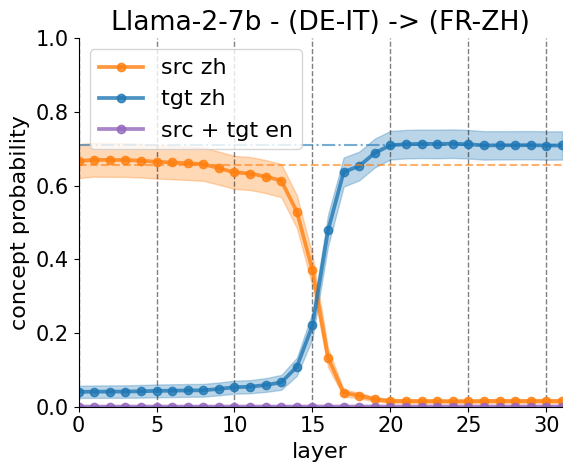

In [6]:
exp2("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/mean_obj_patching/de-it-fr_zh-/1720031987_groovy-dalmatian.json", save_png=True, title="Llama-2-7b - (DE-IT) -> (FR-ZH)")

src zh: 200
tgt zh: 200
src + tgt en: 200
source prompt probs: 200
target prompt probs: 200
32
Saved plot to plots/1721044485nonchalant-boa.pdf


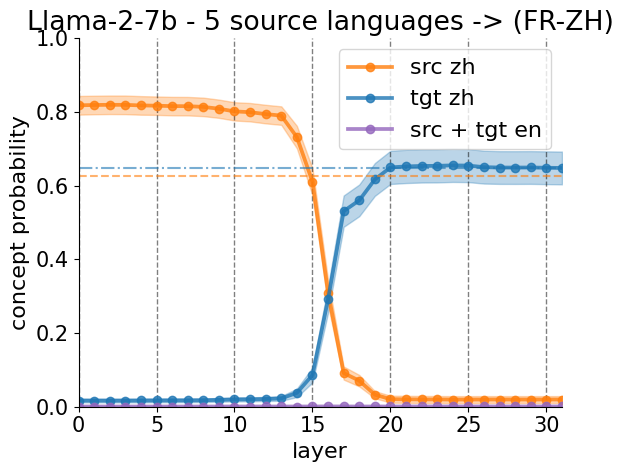

In [7]:
exp2("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/mean_obj_patching/de-it_nl-fi_zh-es_es-ru_ru-ko-fr_zh-/1720276596_athletic-beluga.json", save_png=True, title="Llama-2-7b - 5 source languages -> (FR-ZH)")

src zh: 200
tgt zh: 200
src + tgt en: 200
source prompt probs: 200
target prompt probs: 200
32
Saved plot to plots/1722274551acrid-earwig.pdf


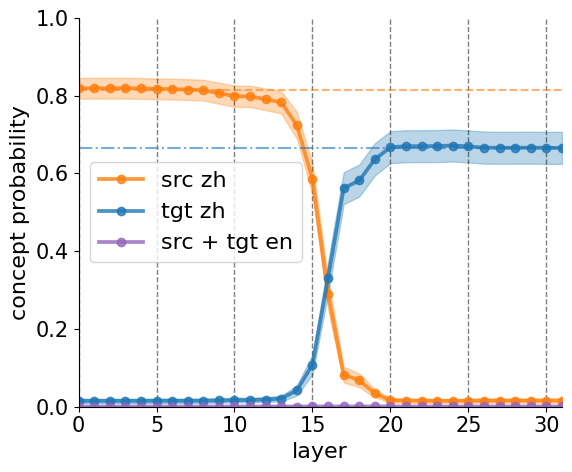

In [6]:
exp2("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/mean_obj_patching/de-zh_nl-zh_zh-zh_es-zh_ru-zh-fr_zh-/1722273184_loutish-dog.json")

## Appendix: Patchscope for other models

tgt zh: 200
source prompt probs: 200
target prompt probs: 200
tgt it: 200
src it: 200
src zh: 200
src + tgt en: 200
32
Saved plot to plots/1720032761thoughtful-raccoon.pdf


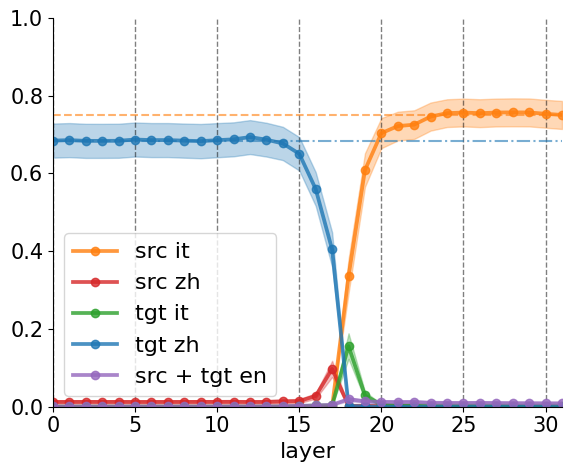

In [23]:
rearange_and_plot2("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Mistral-7B-v0.3/shifted_cross_translation/de_it-fr_zh-/1719939639_tacky-oarfish.json")

tgt zh: 200
source prompt probs: 200
target prompt probs: 200
tgt it: 200
src it: 200
src zh: 200
src + tgt en: 200
32
Saved plot to plots/1720030945pearl-mayfly.pdf


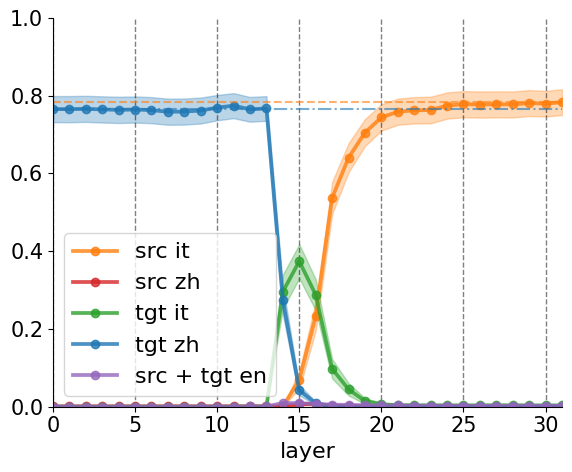

In [19]:
rearange_and_plot2("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Meta-Llama-3-8B/shifted_cross_translation/de_it-fr_zh-/1720000926_spry-swallow.json")

tgt zh: 200
source prompt probs: 200
target prompt probs: 200
tgt it: 200
src it: 200
src zh: 200
src + tgt en: 200
32
Saved plot to plots/1720033177massive-oriole.pdf


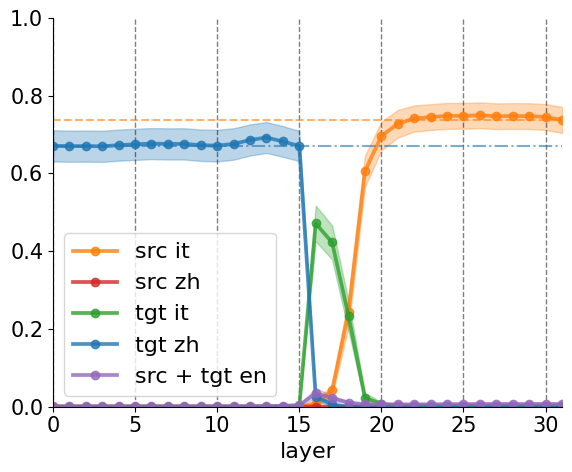

In [33]:
rearange_and_plot2("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Qwen1.5-7B/shifted_cross_translation/de_it-fr_zh-/1720032370_amethyst-puffin.json")

tgt zh: 200
source prompt probs: 200
target prompt probs: 200
tgt it: 200
src it: 200
src zh: 200
src + tgt en: 200
80
Saved plot to plots/1720456619esoteric-magpie.pdf


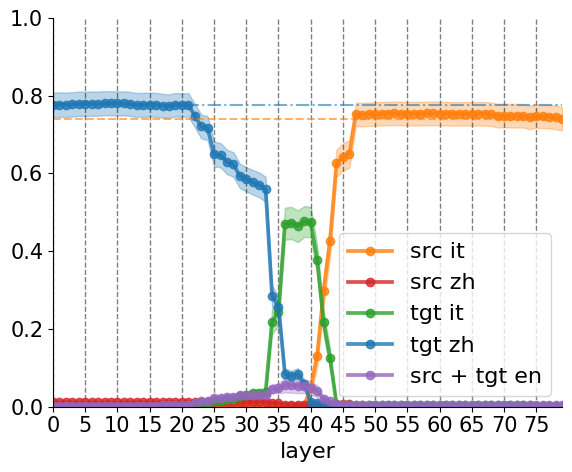

In [15]:
rearange_and_plot2("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-70b/shifted_cross_translation/de_it-fr_zh-/1720292418_woodoo-junglefowl.json")

## Appendix: Random lang

tgt zh: 200
tgt it: 200
target prompt probs: 200
32
Saved plot to plots/1720037697gorgeous-tamarin.pdf


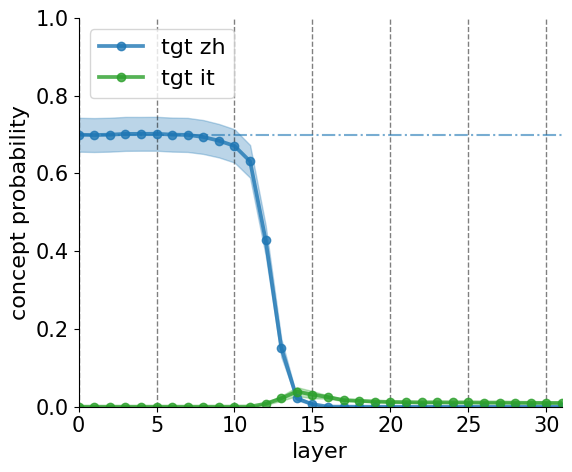

In [64]:
dic = load_dict("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/shifted_cross_translation/de_it-fr_zh/1720000280_accelerated-saluki.json")
dic = {"zh": dic["zh"], "it": dic["it"], "target prompt probs": dic["target prompt probs"]}
plot_dict(dic, colors=["tab:blue", "tab:green"], baseline_colors=["tab:blue", "tab:blue"])

tgt zh: 200
target prompt probs: 200
32
Saved plot to plots/1720100440merry-crab.pdf


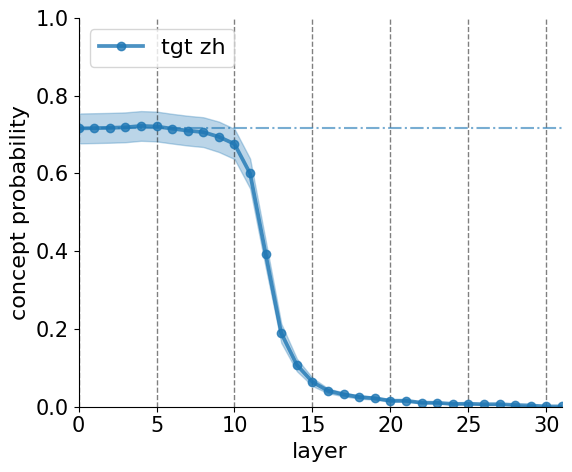

In [6]:
dic = load_dict("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/random_random_translation/fr_zh/1720099751_bizarre-chipmunk.json")
dic = {"zh": dic["zh"], "target prompt probs": dic["target prompt probs"]}
plot_dict(dic, colors=["tab:blue", "tab:green"], baseline_colors=["tab:blue", "tab:blue"])

tgt zh: 200
target prompt probs: 200
32
Saved plot to plots/1720458287massive-trout.pdf


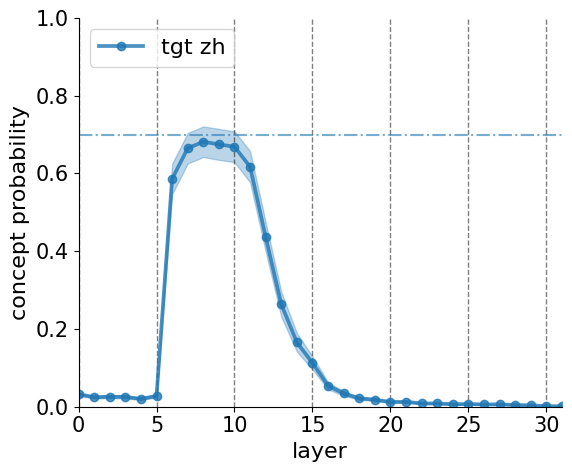

In [22]:
dic = load_dict("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/random_random_translation/fr_zh_64/1720198017_abstract-hyena.json")
dic = {"zh": dic["zh"], "target prompt probs": dic["target prompt probs"]}
plot_dict(dic, colors=["tab:blue"], baseline_colors=["tab:blue", "tab:blue"])

In [23]:
def random_(file):
    dic = load_dict(file)
    dic = {"zh": dic["zh"], "target prompt probs": dic["target prompt probs"]}
    plot_dict(dic, colors=["tab:blue"], baseline_colors=["tab:blue", "tab:blue"])   

tgt zh: 200
target prompt probs: 200
32
Saved plot to plots/1720458639provocative-chicken.pdf


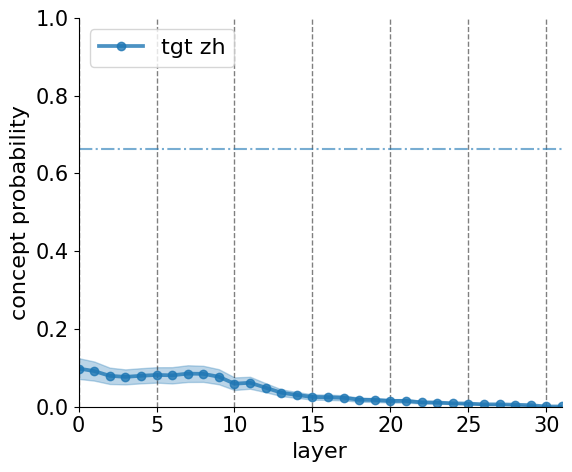

In [24]:
# shuffled @
random_("../generalization/results/Llama-2-7b/random_random_translation/fr_zh_64/1720199024_pretty-spoonbill.json")

tgt zh: 200
target prompt probs: 200
32
Saved plot to plots/1720459144cinnamon-earthworm.pdf


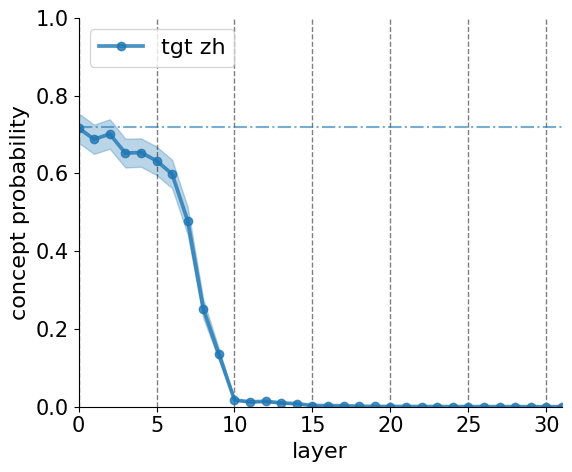

In [25]:
random_("../generalization/results/Llama-2-7b/random_random_translation/fr_zh_34/1720108525_curious-aardwark.json")

## Exp2

### Llama2

src zh: 200
tgt zh: 200
src + tgt en: 200
source prompt probs: 200
target prompt probs: 200
32
Saved plot to plots/1720181207topaz-toad.pdf


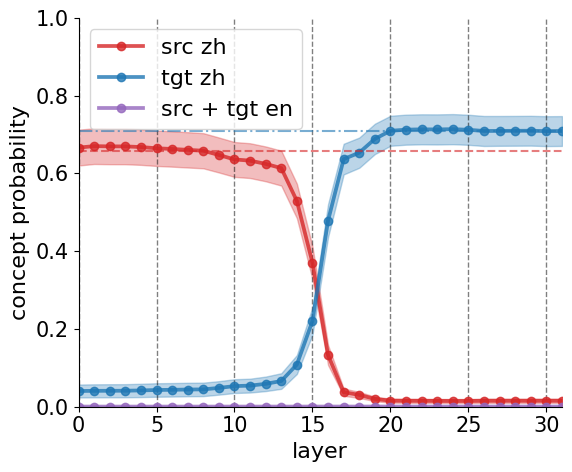

In [5]:
exp2("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/mean_obj_patching/de-it-fr_zh-/1720031987_groovy-dalmatian.json")

src zh: 200
tgt zh: 200
src + tgt en: 200
source prompt probs: 200
target prompt probs: 200
32
Saved plot to plots/1720181208pretty-piculet.pdf


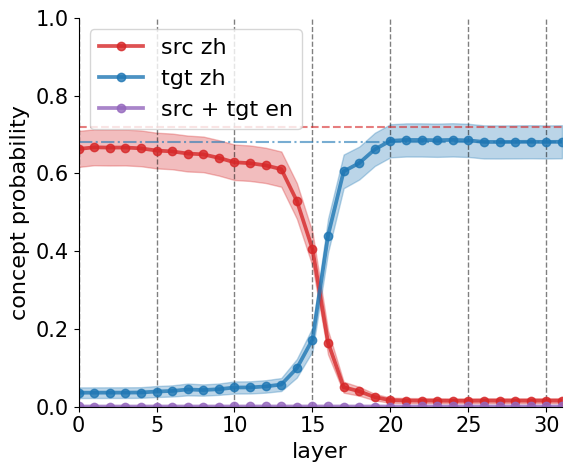

In [6]:
exp2("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/mean_obj_patching/de-it_de-it_de-it_de-it_de-it-fr_zh-/1720011923_quirky-raccoon.json")

src zh: 200
tgt zh: 200
src + tgt en: 200
source prompt probs: 200
target prompt probs: 200
32
Saved plot to plots/1720277877stirring-emu.pdf


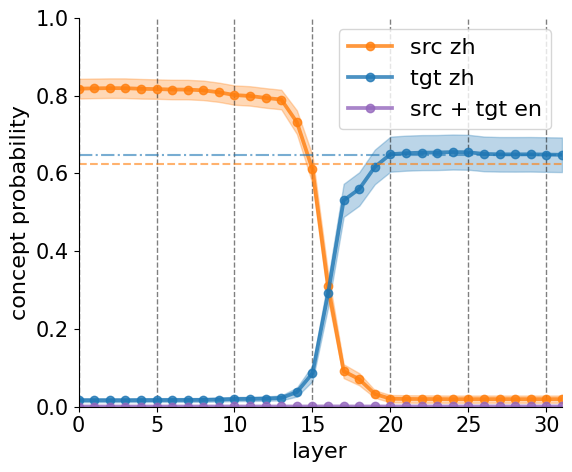

In [5]:
exp2("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/mean_obj_patching/de-it_nl-fi_zh-es_es-ru_ru-ko-fr_zh-/1720276596_athletic-beluga.json")

### Llama3

src zh: 200
tgt zh: 200
src + tgt en: 200
source prompt probs: 200
target prompt probs: 200
32
Saved plot to plots/1720036859cherry-starfish.pdf


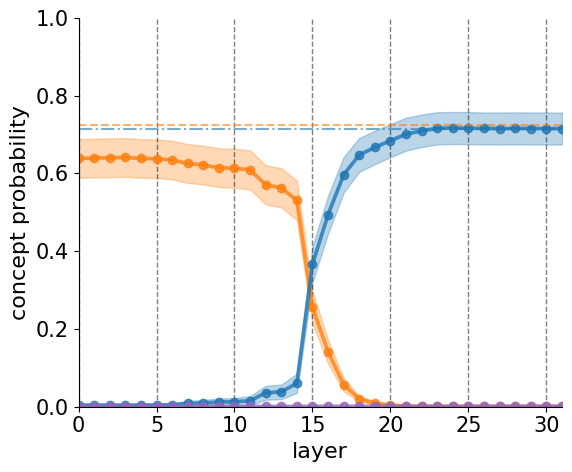

In [56]:
exp2("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Meta-Llama-3-8B/mean_obj_patching/de-it-fr_zh-/1720000469_graceful-dogfish.json", legend=False)

src zh: 200
tgt zh: 200
src + tgt en: 200
source prompt probs: 200
target prompt probs: 200
32
Saved plot to plots/1720036861imperial-dodo.pdf


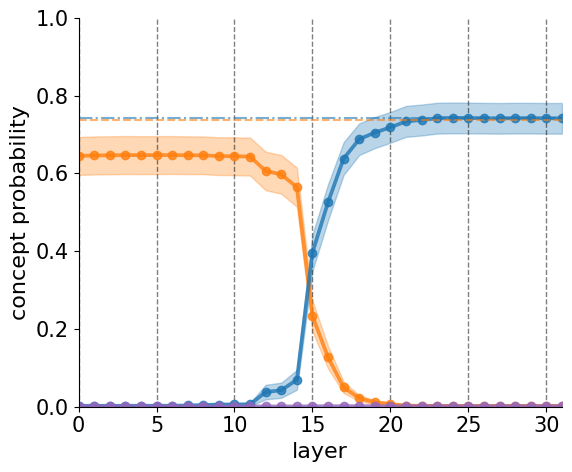

In [57]:
exp2("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Meta-Llama-3-8B/mean_obj_patching/de-it_de-it_de-it_de-it_de-it-fr_zh-/1720000469_graceful-dogfish.json", legend=False)

src zh: 200
tgt zh: 200
src + tgt en: 200
source prompt probs: 200
target prompt probs: 200
32
Saved plot to plots/1720036868hilarious-foxhound.pdf


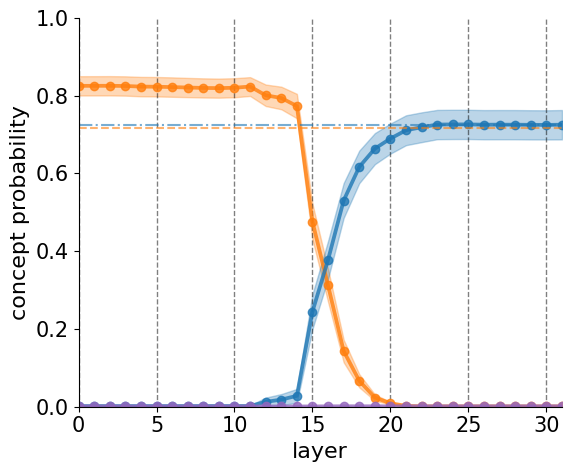

In [58]:
exp2("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Meta-Llama-3-8B/mean_obj_patching/de-fr_nl-fi_zh-es_es-ru_ru-ko-fr_zh-/1720000469_graceful-dogfish.json", legend=False)

### Mistral

src zh: 200
tgt zh: 200
src + tgt en: 200
source prompt probs: 200
target prompt probs: 200
32
Saved plot to plots/1720036627prudent-hamster.pdf


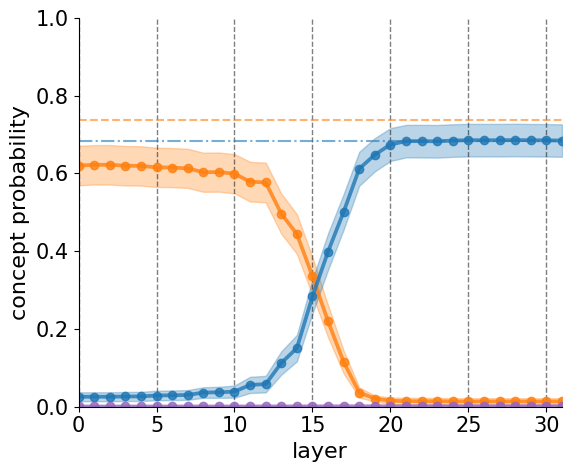

src zh: 200
tgt zh: 200
src + tgt en: 200
source prompt probs: 200
target prompt probs: 200
32
Saved plot to plots/1720036627voracious-camel.pdf


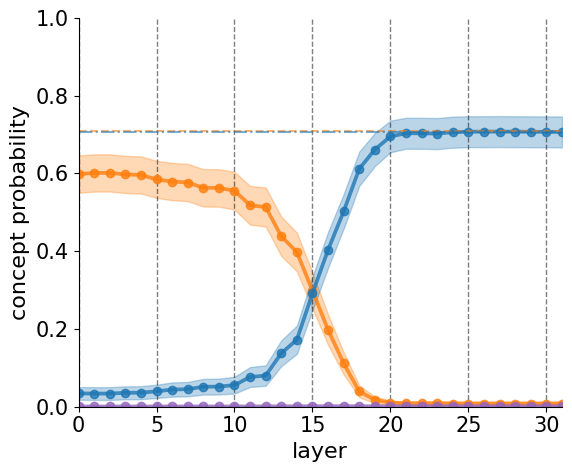

src zh: 200
tgt zh: 200
src + tgt en: 200
source prompt probs: 200
target prompt probs: 200
32
Saved plot to plots/1720036628gabby-dachshund.pdf


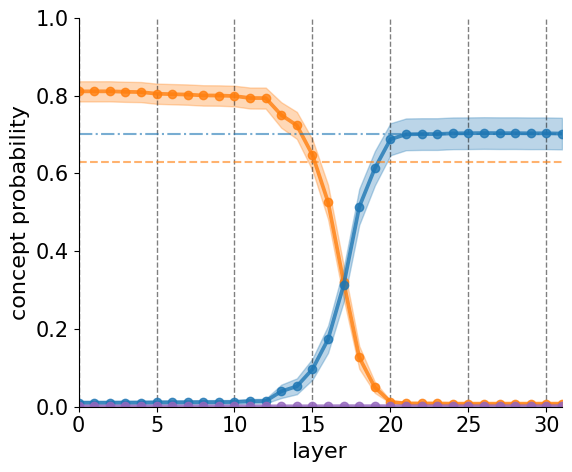

In [55]:
exp2("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Mistral-7B-v0.3/mean_obj_patching/de-it-fr_zh-/1719937868_brave-spaniel.json", legend=False)
exp2("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Mistral-7B-v0.3/mean_obj_patching/de-it_de-it_de-it_de-it_de-it-fr_zh-/1719937868_brave-spaniel.json", legend=False)
exp2("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Mistral-7B-v0.3/mean_obj_patching/de-fr_nl-fi_zh-es_es-ru_ru-ko-fr_zh-/1719937868_brave-spaniel.json", legend=False)

### Llama2-70b

src zh: 200
tgt zh: 200
src + tgt en: 200
source prompt probs: 200
target prompt probs: 200
80
Saved plot to plots/1720455969beryl-kakapo.pdf


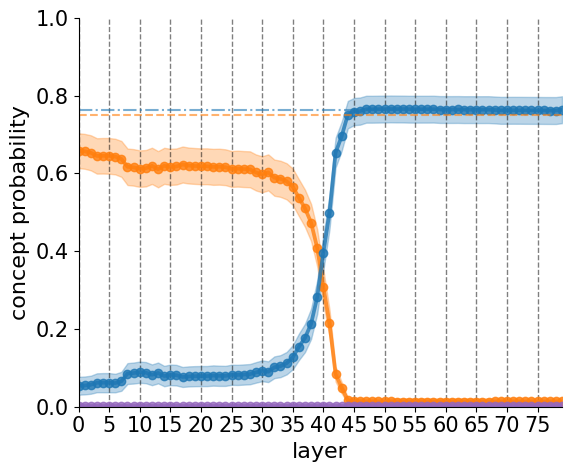

src zh: 200
tgt zh: 200
src + tgt en: 200
source prompt probs: 200
target prompt probs: 200
80
Saved plot to plots/1720455969white-inchworm.pdf


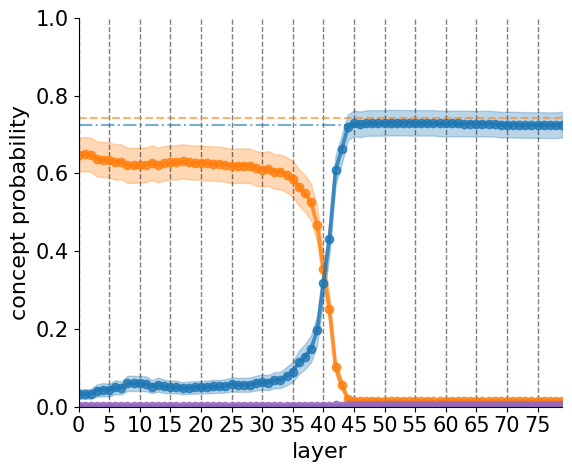

src zh: 200
tgt zh: 200
src + tgt en: 200
source prompt probs: 200
target prompt probs: 200
80
Saved plot to plots/1720455970eminent-beagle.pdf


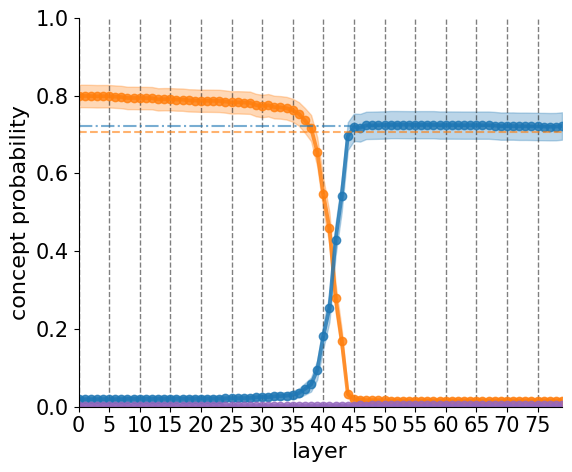

In [9]:
exp2("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-70b/mean_obj_patching/de-it-fr_zh-/1720285782_shaggy-clam.json", legend=False)
exp2("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-70b/mean_obj_patching/de-it_de-it_de-it_de-it_de-it-fr_zh-/1720285782_shaggy-clam.json", legend=False)
exp2("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-70b/mean_obj_patching/de-it_nl-fi_zh-es_es-ru_ru-ko-fr_zh-/1720285782_shaggy-clam.json", legend=False)

## Old

tgt zh: 200
source prompt probs: 200
target prompt probs: 200
tgt it: 200
src it: 200
src zh: 200
src + tgt en: 200
32
Saved plot to plots/1719940881emerald-doberman.pdf


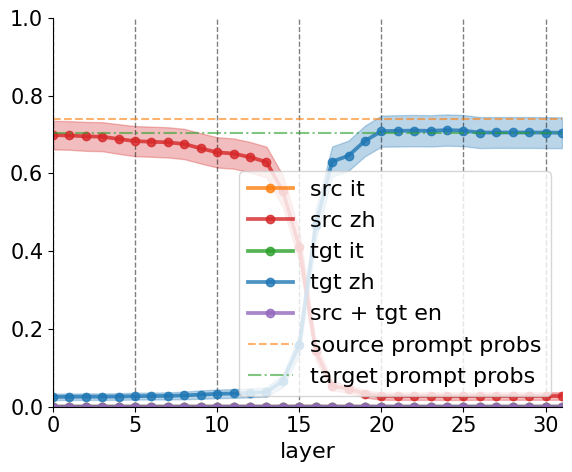

In [75]:
rearange_and_plot2("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/obj_patching/de_it-fr_zh-/1719846677_urban-dachshund.json")

tgt en: 200
src it: 200
tgt it: 200
tgt zh: 200
src zh: 200
src en: 200
source prompt probs: 200
target prompt probs: 200
32
Saved plot to plots/1719940894ebony-condor.pdf


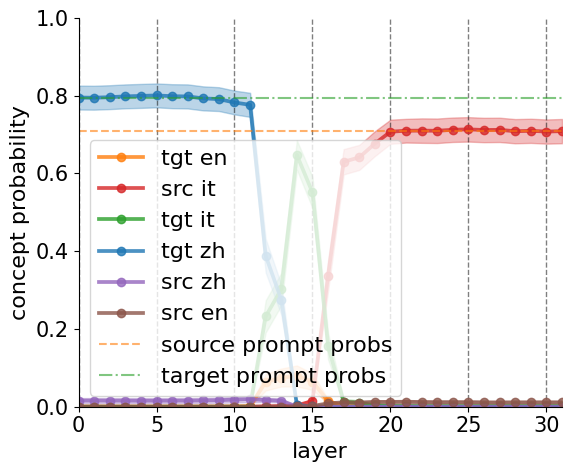

In [76]:
rearange_and_plot("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/shifted_cross_translation/de_it-fr_zh-/1719840482_camouflaged-cuttlefish.json")

0.7951778307557106
0.6834621695271926
dict_keys(['zh', 'source prompt probs', 'target prompt probs', 'it', 'source_it', 'source_zh'])
No entry found for en
tgt zh: 200
source prompt probs: 200
target prompt probs: 200
tgt it: 200
src it: 200
src zh: 200
32
Saved plot to plots/1719941621dazzling-swan.pdf


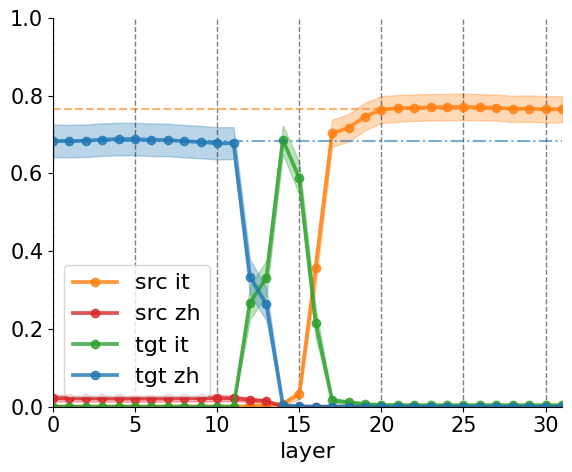

In [88]:
dic = load_dict("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/shifted_cross_translation/de_it-fr_zh-/1719840482_camouflaged-cuttlefish.json")
print(np.mean(dic["target prompt probs"]))
dic = load_dict("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/shifted_cross_translation/de_it-fr_zh-/1719824486_lovely-marten.json")
print(np.mean(dic["target prompt probs"]))
print(dic.keys())
dic = preprocess_dict(dic, merge_lang="en")
dic, colors = rearange(dic)
plot_dict(dic, do_y_label=False, processing=False, colors=colors)

tgt zh: 200
source prompt probs: 200
target prompt probs: 200
tgt it: 200
src it: 200
src zh: 200
src + tgt en: 200
32
Saved plot to plots/1720810348pretty-malkoha.pdf


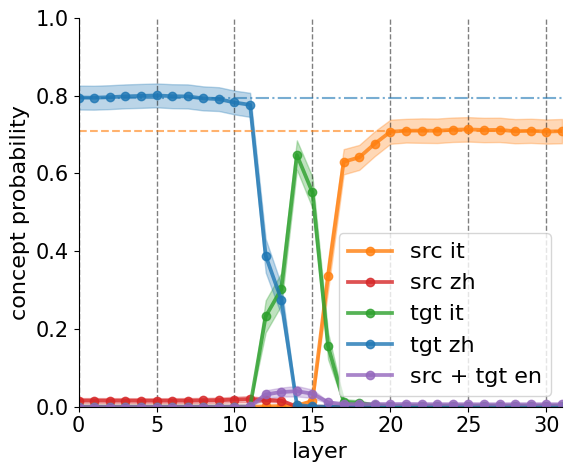

In [4]:
dic = load_dict("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/shifted_cross_translation/de_it-fr_zh-/1719840482_camouflaged-cuttlefish.json")
dic = preprocess_dict(dic, merge_lang="en")
dic, colors = rearange(dic)
plot_dict(dic, do_y_label=True, processing=False, colors=colors)

it: 91
32
Saved plot to plots/1719826722phenomenal-baboon.pdf


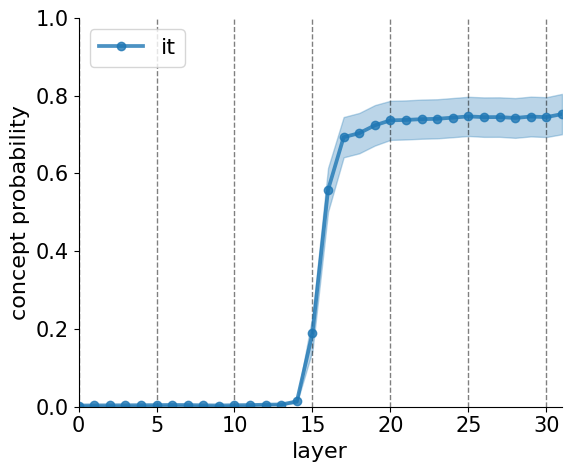

In [7]:
plot_file("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/translation_lens/-de_it-/1719666106_thankful-starfish2.json", do_relabel=False)

it: 38
en: 38
32
Saved plot to plots/1719918932amethyst-serval.pdf


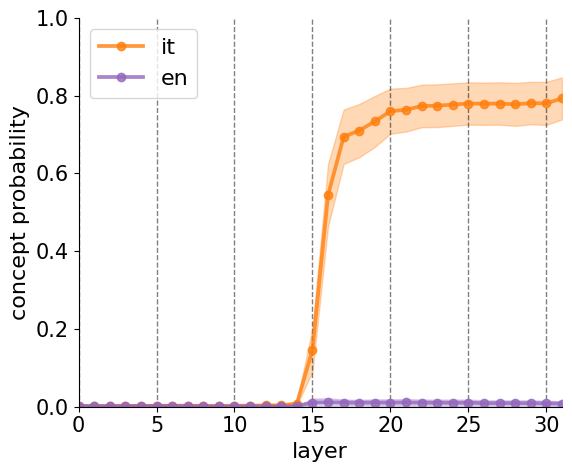

In [16]:
plot_file("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/translation_lens/-de_it-/1719666106_thankful-starfish.json", do_relabel=False, colors=["tab:orange", "tab:purple"])

In [1]:
rearange_and_plot("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/shifted_cross_translation/de_it-fr_zh-/test.json", do_y_label=False)

NameError: name 'rearange_and_plot' is not defined

ru: 46
en: 46
32
Saved plot to plots/1719633111debonair-ocelot.pdf


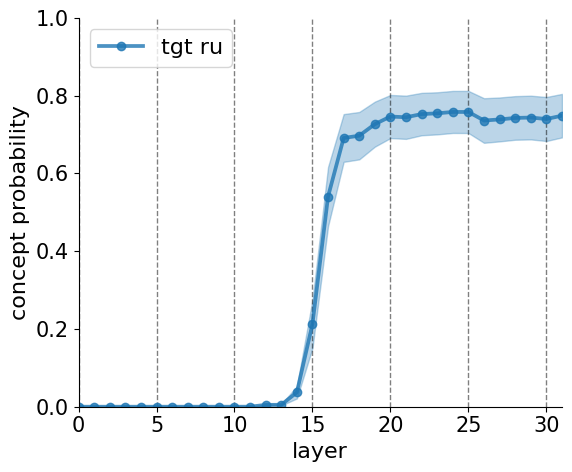

In [6]:
plot_file("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/translation_lens/-zh_ru-/1719632517_sloppy-flounder.json", skip=["tgt en"])

zh: 200
en: 200
source_en: 200
source_zh: 200
32
Saved plot to plots/1718378297ultra-gibbon.pdf


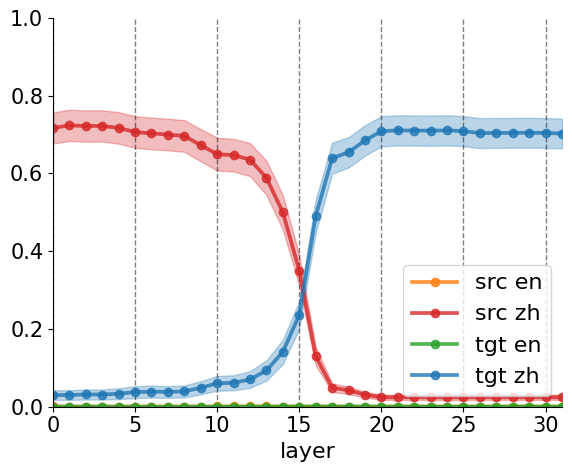

In [8]:
rearange_and_plot("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/steer_obj_patching/de_en-fr_zh-/1717036292courageous-hamster.json", do_y_label=False)

zh: 200
source_zh: 200
32
Saved plot to plots/1718378307adaptable-guan.pdf


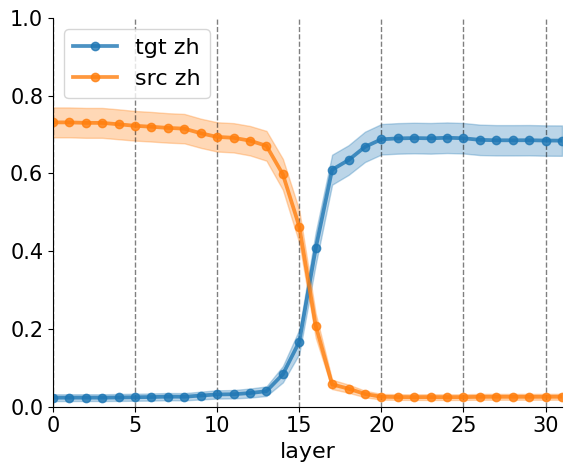

In [13]:
dict_ = load_dict("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/obj_patching/de_en-fr_zh-/1716830016.json")
dict_.keys()
dict_.pop("source_en")
dict_.pop("en")
dict_ = relabel(dict_)
plot_dict(dict_, do_y_label=False)

zh: 200
source_zh: 200
32
Saved plot to plots/1718382063overjoyed-bird.pdf


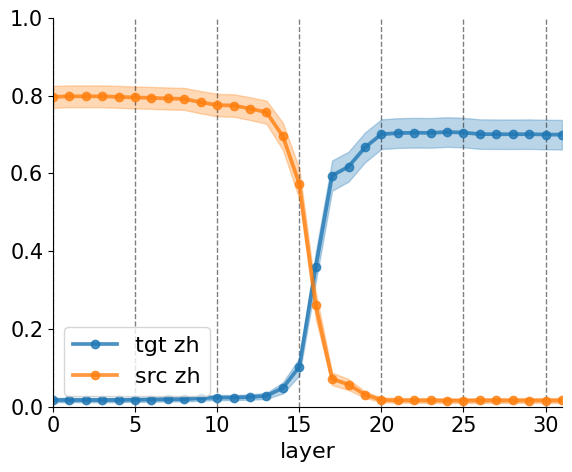

In [16]:
plot_file("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/mean_obj_patching/de-fr_es-hi_ru-de_ja-en_it-ko_de-hi_es-fi_ru-nl_ja-de_it-ru-fr_zh-/1718197020_cerulean-turaco.json", do_y_label=False)

fr: 200
en: 200
source_en: 200
source_fr: 200
32
Saved plot to plots/1717031996organic-malkoha.pdf


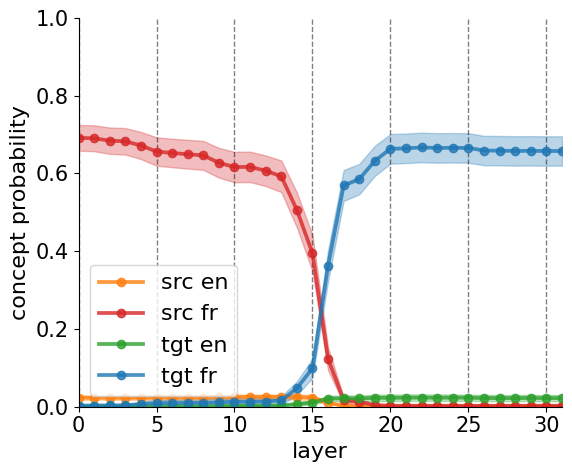

In [ ]:
rearange_and_plot("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/obj_patching/fr_en-de_fr-/1716830016.json")

zh: 200
en: 200
source_en: 200
source_zh: 200
32
Saved plot to plots/1717031926famous-gaur.pdf


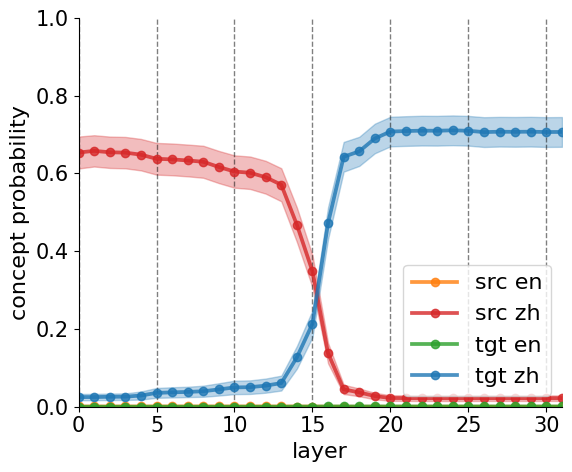

In [ ]:
rearange_and_plot("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/obj_patching/fr_en-fr_zh-/1716830016.json")

In [ ]:
rearange_and_plot("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/obj_patching/fr_en-fr_zh-/1716830016.json")


zh: 200
en: 200
source_en: 200
source_zh: 200
32
Saved plot to plots/1717032145independent-lynx.pdf


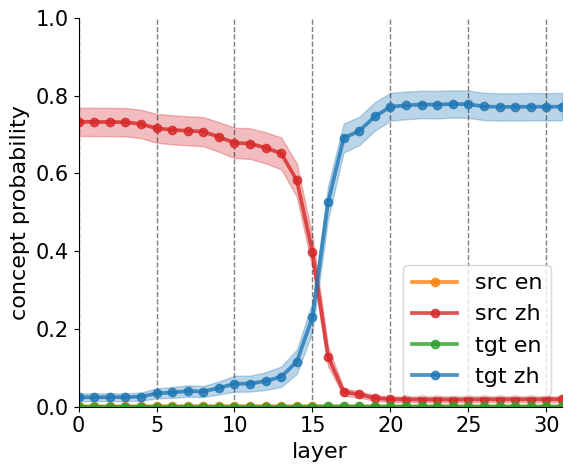

en: 200
zh: 200
source_zh: 200
source_en: 200
32
Saved plot to plots/1717032146sexy-labradoodle.pdf


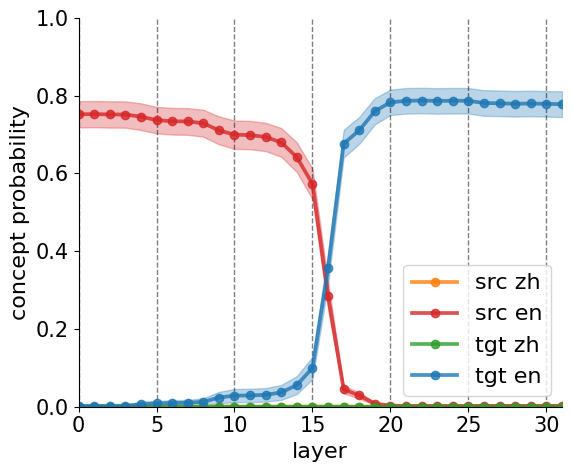

In [ ]:
rearange_and_plot("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/obj_patching/de_en-de_zh-/1716827948.json")
rearange_and_plot("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/obj_patching/de_zh-de_en-/1716830016.json")

zh: 200
en: 200
source_en: 200
source_zh: 200
32
Saved plot to plots/1717032035dark-penguin.pdf


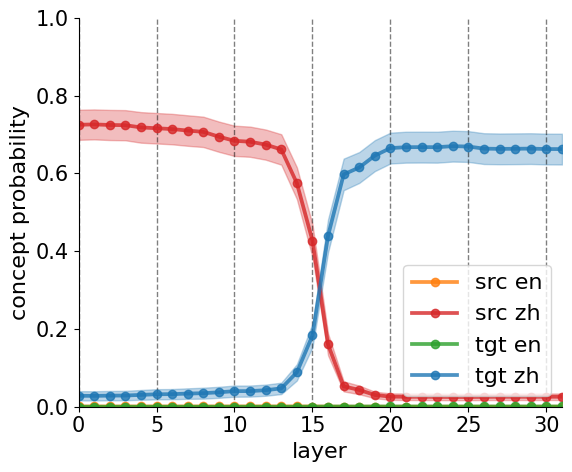

zh: 200
en: 200
source_en: 200
source_zh: 200
32
Saved plot to plots/1717032036unselfish-gerbil.pdf


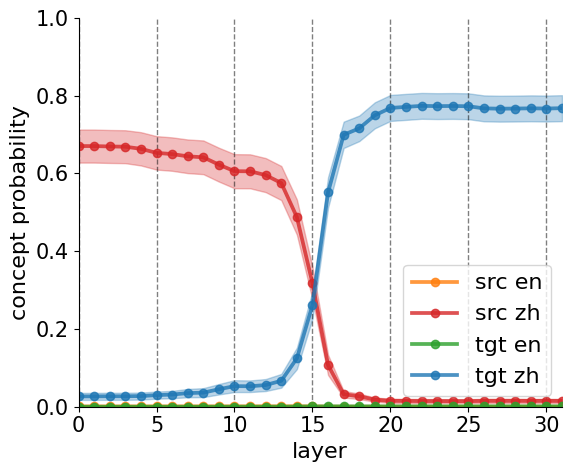

In [ ]:
rearange_and_plot("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/obj_patching/de_en-fr_zh-/1716827948.json", do_y_label=True)
rearange_and_plot("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/obj_patching/fr_en-de_zh-/1716830016.json")

en: 200
de: 200
source_de: 200
source_en: 200
32
Saved plot to plots/1716913147quick-chimpanzee.pdf


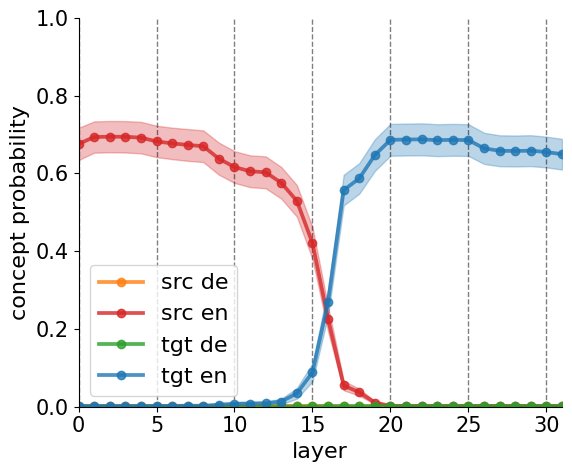

In [ ]:
rearange_and_plot("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/obj_patching/fr_de-zh_en-/1716830016.json", do_y_label=True)

zh: 200
en: 200
source_en: 200
source_zh: 200
32
Saved plot to plots/1716911528.pdf


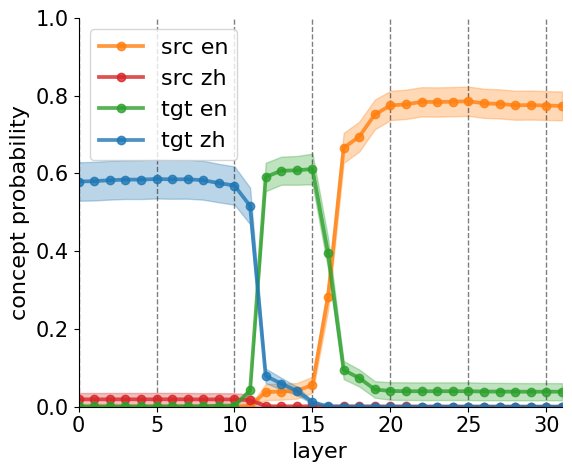

In [ ]:
rearange_and_plot("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/shifted_cross_translation/de_en-de_zh-/1716404338.json")

en: 200
fr: 200
source_fr: 200
source_en: 200
32
Saved plot to plots/1716911994.pdf


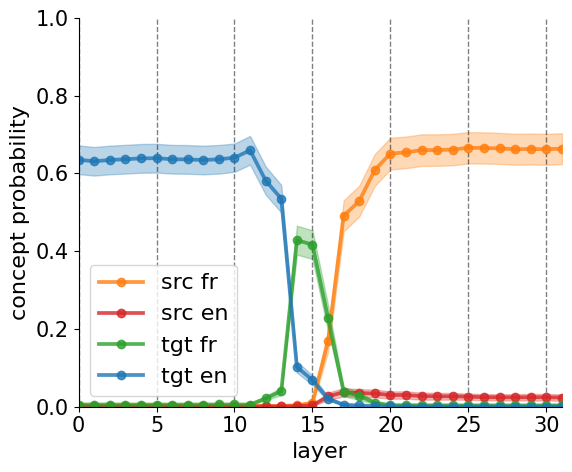

In [ ]:
rearange_and_plot("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/shifted_cross_translation/de_fr-zh_en-/test.json")

ru: 200
en: 200
source_en: 200
source_ru: 200
32
Saved plot to plots/1716913667winged-lizard.pdf


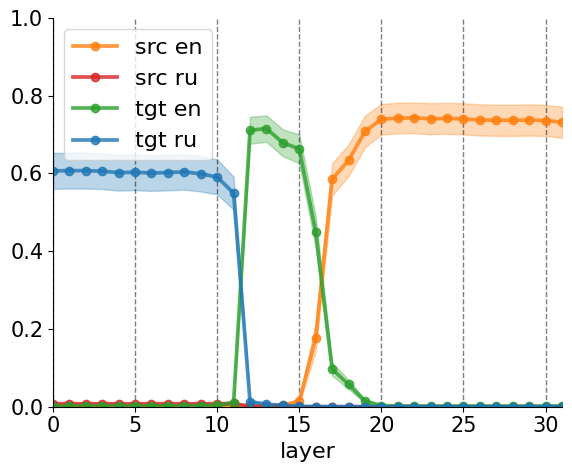

In [ ]:
rearange_and_plot("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/shifted_cross_translation/fr_en-de_ru-/test.json", do_y_label=False)

ru: 200
fr: 200
source_fr: 200
source_ru: 200
32
Saved plot to plots/1716913765adorable-eel.pdf


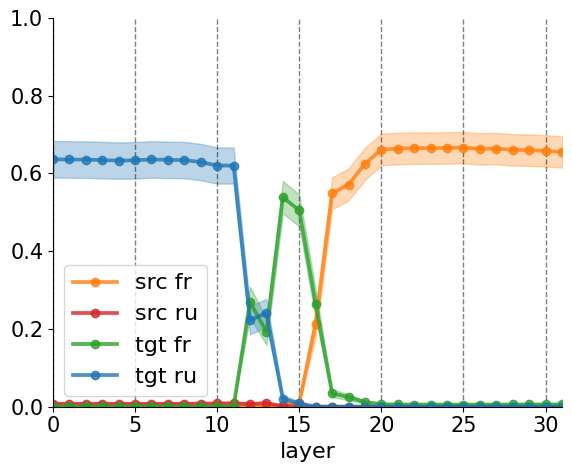

In [ ]:
rearange_and_plot("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/shifted_cross_translation/de_fr-de_ru-/test.json", do_y_label=False)

fr: 200
ru: 200
source_ru: 200
source_fr: 200
32
Saved plot to plots/1716913978rough-turtle.pdf


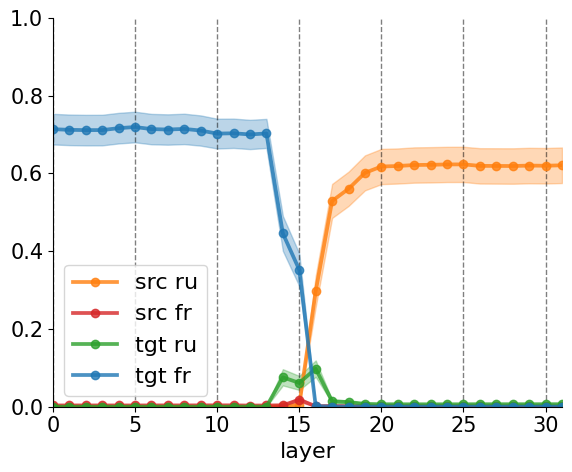

In [ ]:
rearange_and_plot("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/shifted_cross_translation/de_ru-en_fr-/test.json", do_y_label=False)

en: 200
zh: 200
source_zh: 200
source_en: 200
32
Saved plot to plots/1716914674wild-curassow.pdf


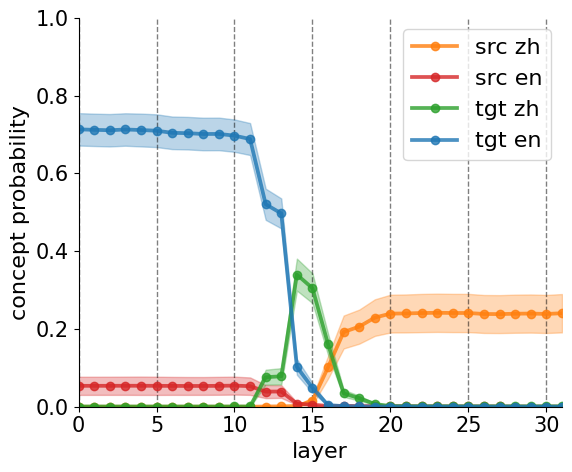

In [ ]:
rearange_and_plot('/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/shifted_cross_translation/fr_zh-fr_en-/1716295083.json')

In [ ]:
rearange_and_plot("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/shifted_cross_translation/en_zh-fr_en-/test.json", do_y_label=False)

FileNotFoundError: [Errno 2] No such file or directory: '/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/shifted_cross_translation/en_zh-fr_en-/test.json'

en: 200
ru: 200
source_ru: 200
source_en: 200
32
Saved plot to plots/1716913929tan-quokka.pdf


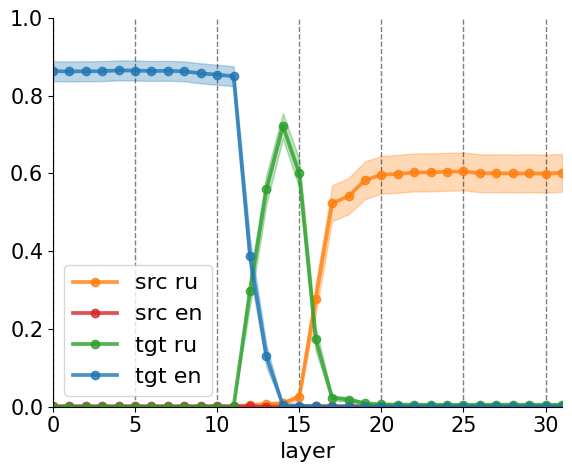

In [ ]:
rearange_and_plot("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/shifted_cross_translation/de_ru-ru_en-/test.json", do_y_label=False)

zh: 200
en: 200
source_en: 200
source_zh: 200
32
Saved plot to plots/1716911529.pdf


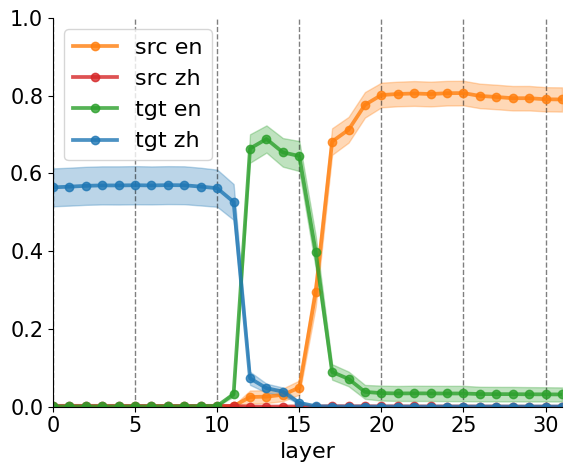

In [ ]:
dic = load_dict("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/shifted_cross_translation/de_en-fr_zh-/1716404338.json")
dic = {}
for key in dic.keys():
    val = dic[key]
    if "probs" in key:
        continue
    if "source_" in key:
        dic[key.replace("source_", "src ")] = val
    else:
        dic["tgt " + key] = val
    print(f"{key}: {len(val)}")
dic2 = {}
idx = [2, 3, 1, 0]
idx2 = [1, 3, 2, 0]
colors = sns.color_palette("tab10", len(dic) + 1)
colors = [colors[i] for i in idx2]
keys = list(dic.keys())
keys3 = [keys[i] for i in idx]
for key in keys3:
    dic2[key] = dic[key]

plot_dict(dic2, colors=colors, do_y_label=False)

In [ ]:
# plot_file2("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/cross_translation/de_en-fr_zh-/1716489708.json", "Paired Translation (de → en) into (fr → zh)", ["de"])
dic = load_dict("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/cross_translation/de_en-de_zh-/1716489708.json")
# dic2 = {
#     "zh (tgt)
plot_file("/dlabscratch1/cdumas/llm-latent-language/generalization/results/Llama-2-7b/cross_translation/de_en-de_zh-/1716489708.json", "", ["de"])

zh: 91
source_prompt_baseline: 91
target_prompt_baseline: 91
de: 91
en: 91


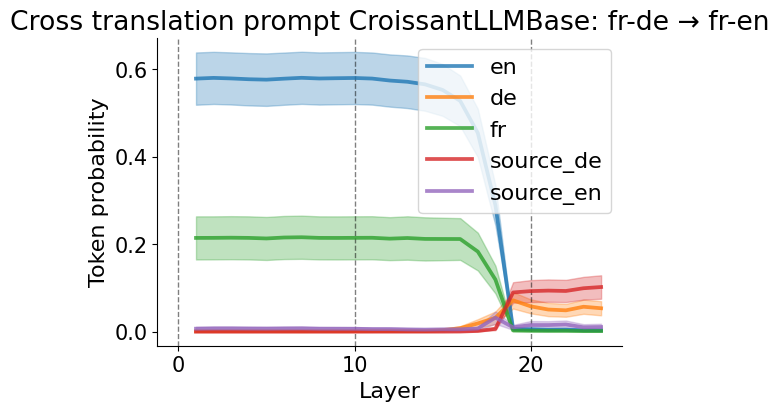

In [ ]:
plot_file("/dlabscratch1/cdumas/llm-latent-language/generalization/results/CroissantLLMBase/cross_translation/fr_de-fr_en-/1716243810.json", "CroissantLLMBase")

In [ ]:
# def plot_file(file, model_name):
#     input_lang = file.split("/")[-1].split("_")[0]
#     target_lang = file.split("/")[-1].split("_")[1]
#     latent_langs = file.split("/")[-1].split("_")[2:-1]
#     with open(file, "r") as f:
#         json_dic = json.load(f)
#     _, ax = plt.subplots(figsize=(6, 4))
#     colors = sns.color_palette("tab10", len(json_dic) + 1)
#     target_probs = th.tensor(json_dic[target_lang])
#     plot_ci(ax, target_probs, label=target_lang, color=colors[0])
#     colors = {lang: color for lang, color in zip(latent_langs, colors[1:])}
#     for latent_lang in latent_langs:
#         probs = th.tensor(json_dic[latent_lang])
#         plot_ci(ax, probs, label=latent_lang, color=colors[latent_lang], do_lines=False)
#     ax.legend()
#     ax.set_title(
#         f"Logit Lens on {model_name}: {input_lang.capitalize()} → {target_lang.capitalize()}"
#     )
#     ax.tick_params(labelsize=15)
#     ax.set_xlabel("Layer", fontsize=16)
#     ax.set_ylabel("Token probability", fontsize=16)
#     # Save the plot
#     path = Path(
#         f"plots/{model_name}_art/{input_lang}_{target_lang}_{'_'.join(latent_langs)}_{str(int(time()))}.png"
#     )
#     path.parent.mkdir(parents=True, exist_ok=True)
#     plt.savefig(path, dpi=300, bbox_inches="tight")
#     plt.show()

In [ ]:
from utils import plot_ci
# plt.rcParams.update({"font.size": 16})
# plt_params = {"linewidth": 2.7, "alpha": 0.8}


# def plot_ci(
#     ax,
#     data,
#     label,
#     color="blue",
#     linestyle="-",
#     tik_step=10,
#     do_lines=True,
#     plt_params=plt_params,
# ):
#     if do_lines:
#         upper = max(round(data.shape[1] / 10) * 10 + 1, data.shape[1] + 1)
#         ax.set_xticks(np.arange(0, upper, tik_step))
#         for i in range(0, upper, tik_step):
#             ax.axvline(i, color="black", linestyle="--", alpha=0.5, linewidth=1)
#     mean = data.mean(dim=0)
#     std = data.std(dim=0)
#     data_ci = {
#         "x": np.arange(data.shape[1]) + 1,
#         "y": mean,
#         "y_upper": mean + (1.96 / (data.shape[0] ** 0.5)) * std,
#         "y_lower": mean - (1.96 / (data.shape[0] ** 0.5)) * std,
#     }

#     df = pd.DataFrame(data_ci)
#     # Create the line plot with confidence intervals
#     ax.plot(
#         df["x"], df["y"], label=label, color=color, linestyle=linestyle, **plt_params
#     )
#     ax.fill_between(df["x"], df["y_lower"], df["y_upper"], color=color, alpha=0.3)
#     if do_lines:
#         ax.spines[["right", "top"]].set_visible(False)

In [ ]:
# plot_file("results/translation/fr_de_en_1714070982.json", "Llama-3-8B")